In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1278
┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278
┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1278


In [2]:
n_events = 31
n_cameras = 3

prior_ang = NamedTupleDist(
    θ = [10^-20 .. 10^-4 for i in 1:n_events],
    α = [0 .. 2*pi  for i in 1:n_events],
    x0 = [-5 .. 5 for i in 1:n_cameras],
    y0 = [-5 .. 5 for i in 1:n_cameras],
    σ_x = [10^-11 .. 0.2 for i in 1:n_cameras],
    σ_y = [10^-11 .. 0.2 for i in 1:n_cameras],
);

In [3]:
function hist_1d(samples, dim_1, nbins)
    smpl_tmp, smpl_w = flatview(unshaped.(samples.v)), samples.weight
    hist_v = fit(Histogram, smpl_tmp[dim_1,:], FrequencyWeights(round.(Int64, smpl_w)), nbins)
    hist_v = normalize(hist_v, mode=:pdf)
    return hist_v
end

function hist_1d_log(samples, dim_1, nbins)
    smpl_tmp, smpl_w = flatview(unshaped.(samples.v)), samples.weight
    hist_v = fit(Histogram, log.(smpl_tmp[dim_1,:]), FrequencyWeights(round.(Int64, smpl_w)), nbins)
    hist_v = normalize(hist_v, mode=:pdf)
    return hist_v
end

hist_1d_log (generic function with 1 method)

In [4]:
@load "../../data/sampling_results/Benchmark-5/alignment/hc-data.jld2" data fit_par_values

2-element Array{Symbol,1}:
 :data
 :fit_par_values

In [5]:
fit_par_values[1]

(θ = [5.435227144820352e-7, 1.4060390057965052e-7, 1.737198980360051e-8, 3.226419023720061e-6, 1.5914231831297492e-6, 1.899521676909478e-6, 1.1100563772670382e-6, 8.76508244330532e-7, 1.9397587339218714e-6, 1.9823063792366517e-6  …  1.2361995818200385e-5, 1.3615640919533689e-5, 1.291435368495275e-5, 1.3212060164584989e-6, 2.4065644211727234e-7, 1.1965212837243865e-6, 2.7748187805111776e-6, 1.556036194859234e-6, 8.93727411066152e-6, 1.6991516185074752e-6], α = [5.931781792745693, 4.881869333971324, 1.281962343288671, 0.7773691200500432, 3.922252379429369, 2.6699429875893346, 0.10186173597583599, 1.9785082421303741, 0.7915503374171421, 2.7665673809192612  …  1.746639450422138, 1.833988048563111, 1.5647157176843784, 3.7235789529916503, 6.069453693483471, 2.508753186473447, 2.7970189352639623, 3.1961303487466926, 3.173114067037641, 2.043124173822388], x0 = [-0.16614864396381018, 1.5255947720693261, 3.375177104208062], y0 = [-0.24819571467950508, 1.4051535975215936, 2.926370874335178], σ_x 

In [6]:
smpl = bat_read("../../data/sampling_results/Benchmark-5/alignment/hc-samples.hdf5")
smpl = varshape(prior_ang).(smpl);

In [7]:
smpl_flat, smpl_w = flatview(unshaped.(smpl.v)), smpl.weight;

In [28]:
# az_angles = log.(mode(smpl).θ)
 az_angles = log.(fit_par_values[1].θ)

az_angles = az_angles .- minimum(az_angles)
az_angles = az_angles ./ maximum(az_angles)
legend_tmp = log.(fit_par_values[1].θ);

In [29]:
nbins = range(0, stop=2*pi, length=250)
hist_array = [hist_1d(smpl, i, nbins) for i in n_events+1:2*n_events];

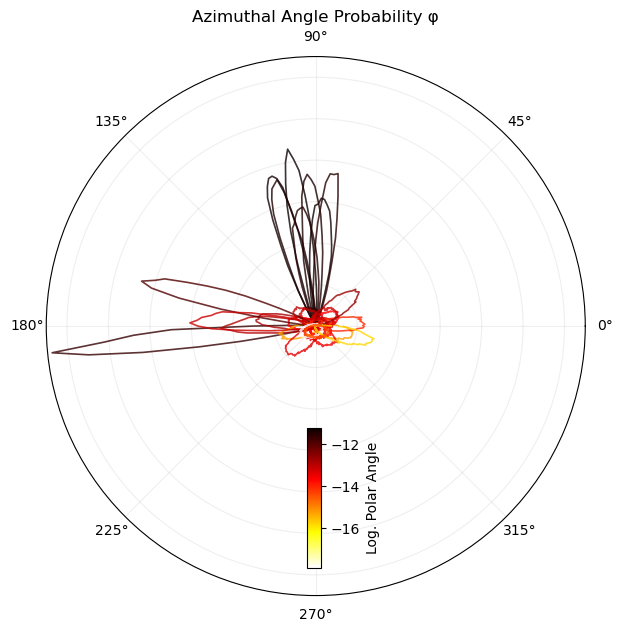

PyObject Text(0.5, 1.0490620490620493, 'Azimuthal Angle Probability φ')

In [30]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

for i in eachindex(hist_array)[end:-1:1]
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.2,  "o-", 
        color= plt.cm.hot_r(az_angles[i]), 
        alpha=0.8, 
        marker="None") 
end

cb = ax.scatter(az_angles, az_angles, lw=0.0,  s=0.0, c=legend_tmp, cmap="hot_r")
ax_ins_3 = fig.add_axes([0.5,0.15,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Log. Polar Angle", cax=ax_ins_3)

#color=plt.cm.Spectral(i/length(hist_array))
ax.grid(alpha=0.2)
# ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_ylim(0, 6.5)
ax.set_title("Azimuthal Angle Probability φ")

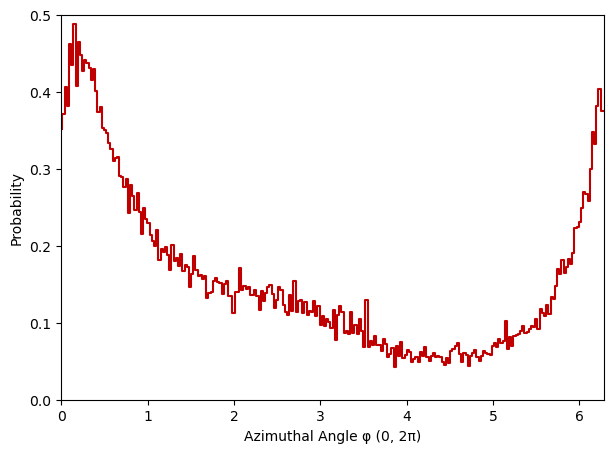

PyObject Text(24.000000000000007, 0.5, 'Probability')

In [63]:
hist_tmp = hist_array[15]

fig, ax= plt.subplots(1,1, figsize=(7,5), )

ax.step(midpoints(hist_tmp.edges[1]), hist_tmp.weights, color=plt.cm.hot_r(az_angles[15]))

ax.set_ylim(0, 0.5)
ax.set_xlim(0, 2*pi)
ax.set_xlabel("Azimuthal Angle φ (0, 2π)")
ax.set_ylabel("Probability")



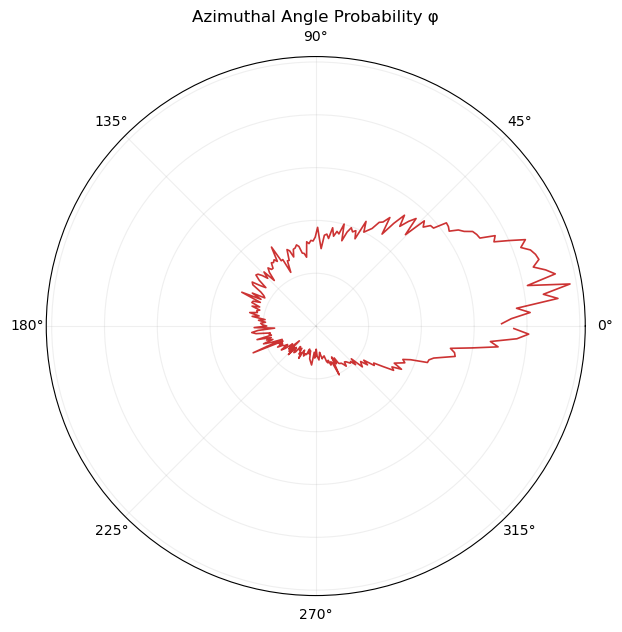

PyObject Text(0.5, 1.049062049062049, 'Azimuthal Angle Probability φ')

In [51]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

ax.plot(midpoints(hist_tmp.edges[1]), 
        hist_tmp.weights, 
        lw=1.2,  "o-", 
        color= plt.cm.hot_r(az_angles[15]), 
        alpha=0.8, 
        marker="None") 

#color=plt.cm.Spectral(i/length(hist_array))
ax.grid(alpha=0.2)
# ax.set_ylabel("")
ax.set_yticklabels([])
# ax.set_ylim(0, 6.5)
ax.set_title("Azimuthal Angle Probability φ")

In [11]:
nbins_2 = range(-20, stop=-10, length=200)
hist_array_2 = [hist_1d_log(smpl, i, nbins_2) for i in 1:n_events];

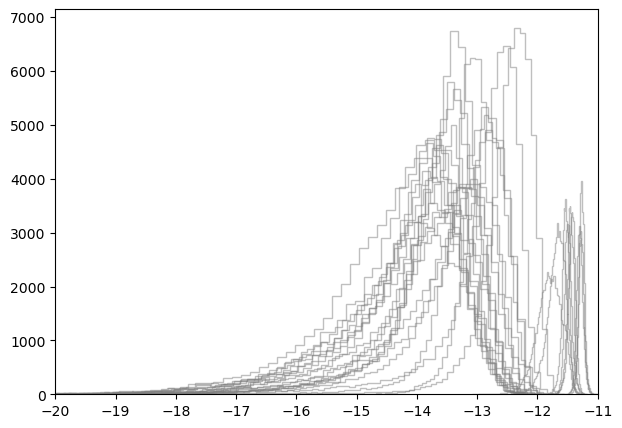

(-20.0, -11.0)

In [12]:
fig, ax= plt.subplots(1,1, figsize=(7,5), )

for i in eachindex(hist_array)
    ax.hist(log.(smpl_flat[i,:]), weights=smpl_w, 100, histtype = "step", color="gray", alpha=0.5)
end
ax.set_xlim(-20, -11)


In [13]:
function plot_lines(mpar, data, smax)
    
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(111, projection="3d")
    
    x_min = minimum([i[1] for i in data.x_event])
    y_min = minimum([i[1] for i in data.y_event])

    for i in eachindex(hist_array)[end:-1:1]

        x_expected = cos(mpar.α[i])*tan(mpar.θ[i])*smax*10^3
        y_expected = sin(mpar.α[i])*tan(mpar.θ[i])*smax*10^3

        x = [data.x_event[i][1] - x_min, data.x_event[i][1] - y_min  + x_expected]*1000
        y = [data.y_event[i][1] - y_min, data.y_event[i][1] - y_min  + y_expected]*1000
        z = [0.0, data.s_cam[end]]

        ax.plot(z, x, y,
            lw=1.2,
            color= plt.cm.hot_r(az_angles[i]), 
            "o-", 
            alpha=0.8, 
        ) 
    end
    
#     cb = ax.scatter(az_angles, az_angles, lw=0.0,  s=0.0, c=legend_tmp, cmap="hot_r")
#     ax_ins_3 = fig.add_axes([0.5,0.15,0.02,0.2])
#     fig.colorbar(cb, spacing="proportional", label="Log. Polar Angle", cax=ax_ins_3)


    ax.set_xlabel("Beamline (m)")
    ax.set_ylabel(L"\mu_x \; (μm)")
    ax.set_zlabel(L"\mu_y \; (μm)")
    
end

plot_lines (generic function with 1 method)

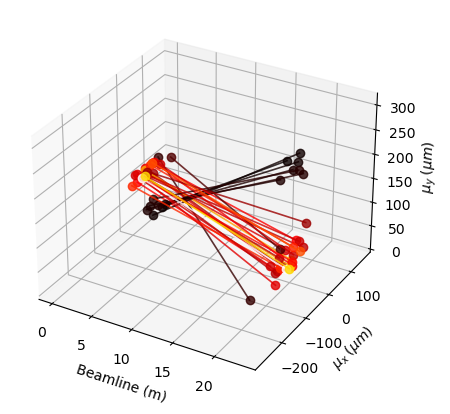

PyObject Text(0.10675873527355245, 0.014302958450758128, '$\\mu_y \\; (μm)$')

In [14]:
plot_lines(fit_par_values[1], data, 24)

In [15]:
x_array = [i[1] for i in data.x_event]
y_array = [i[1] for i in data.y_event]
θ_array = fit_par_values[1].θ
α_array = fit_par_values[1].α;

# Combined Results: 

In [16]:
x_lc = [0.9082688603006076, 0.9791934233017083, 0.8896746934461729, 0.9048437809761471, 0.9015534297206127, 0.9552558022440436, 0.9816945344800468, 0.9714995964981143, 0.9738391566217356, 0.8764057869276578, 0.9015676452196713, 0.9020488277779724, 0.9067250995426688, 0.9946429288103903, 0.8741115852445387, 0.8617563114834886, 0.9262276698055143, 0.9706960174928068, 0.9376314828731124, 0.9265085771587754, 0.8672475339379943, 0.903449365554591, 0.9167021731597848, 1.000428147170022, 0.9171315708866935, 0.9597692514606075, 0.9709881468939575, 0.8630236510829894, 0.9412238186129168, 0.9547879965322923, 0.9909170120565612, 0.9811104821283969, 0.9830297319548715, 1.111399356192117, 0.8805218367198636]
y_lc = [1.0937156489719408, 1.0949538642248176, 1.1085143572602691, 1.0925316236736275, 1.0901588293316864, 1.0740655814588709, 1.1055210583441617, 1.0899431511475646, 1.073103528064759, 1.0940804793111405, 1.0894080745963208, 1.091446474233016, 1.1063580415115646, 1.1050733596751545, 1.0948190338730577, 1.092959580749493, 1.0888317156536162, 1.089111025313861, 1.0807230586783592, 1.087692662442382, 1.1058635002941652, 1.1062063399509212, 1.0615676455415182, 1.0936766313301052, 1.0715008726653386, 1.054326483297732, 1.0678734652269195, 1.107954626921738, 1.0879652600807717, 1.108085471224564, 1.1068576855592571, 1.1044910949247775, 1.0935455361061508, 1.1007449291495806, 1.0934820575409105];
θ_lc = [3.810311221409573e-6, 4.874668619154936e-6, 1.2723030489949665e-6, 1.4730112547866368e-6, 1.931737761902975e-6, 1.1151300145406649e-6, 3.75481915125512e-7, 2.036983570858537e-6, 2.1404247015236896e-6, 1.313353900966594e-6, 1.9664406846372675e-6, 1.5832393677450918e-6, 8.855537333755893e-7, 7.041652606609142e-6, 9.300640247889132e-7, 2.3669999792593615e-6, 1.4575537252766702e-6, 1.4133218220178648e-6, 3.7470450352593283e-6, 8.064905497767496e-7, 1.85513782830137e-6, 2.7985322538700786e-6, 3.539412161159097e-6, 7.705013343750041e-6, 4.463506863354066e-6, 4.993525549068069e-6, 5.7734070057913545e-6, 1.5829945245398083e-6, 1.440438620853754e-6, 9.443493998309782e-7, 5.321219852391566e-6, 6.422192610354442e-7, 3.4724754705351537e-7, 1.3966497576864415e-5, 2.3749459727985422e-6];
α_lc = [0.061977463257672526, 3.130723949460696, 2.8515534648975374, 6.269090750677613, 1.2269768490237627, 1.3578854918145558, 2.82111001974541, 2.5762923191628335, 1.6093737735078697, 0.13288036318662427, 1.9910933561038786, 3.5611112383533685, 2.126012022216004, 3.150150379397583, 2.5942227993578983, 0.5014994369076379, 0.8644566877519532, 2.3287128971119464, 2.4033463237505366, 1.1387100026072692, 0.13982782384033712, 3.317526069826696, 1.1106106072090358, 3.1291567611221023, 1.44373053650078, 1.5721651898746567, 0.7583134384556466, 5.221263471629342, 1.7990628203329506, 3.5057024408520188, 3.2749818182842834, 0.19857213703303236, 2.8692677334220775, 3.1303408247375764, 2.8734587368296447];
q_lc = [9.017000198364258, 9.514900207519531, 8.502799987792969, 9.030599594116211, 9.336899757385254, 7.766900062561035, 9.496800422668457, 8.863100051879883, 9.418399810791016, 8.154500007629395, 9.160099983215332, 8.99940013885498, 9.308199882507324, 10.11870002746582, 9.459699630737305, 8.551199913024902, 9.35509967803955, 9.9931001663208, 8.054900169372559, 9.28279972076416, 9.5556001663208, 8.590900421142578, 8.968799591064453, 9.020899772644043, 10.308500289916992, 8.56980037689209, 9.664600372314453, 9.695500373840332, 8.070199966430664, 9.549400329589844, 10.215499877929688, 9.51930046081543, 9.426400184631348, 9.346099853515625, 8.984100341796875];
run_id_lc = [316.0, 325.0, 326.0, 327.0, 328.0, 452.0, 329.0, 330.0, 466.0, 331.0, 484.0, 332.0, 333.0, 334.0, 317.0, 335.0, 336.0, 337.0, 540.0, 338.0, 339.0, 340.0, 577.0, 318.0, 658.0, 670.0, 684.0, 319.0, 363.0, 320.0, 321.0, 322.0, 323.0, 395.0, 324.0];

In [17]:
x_hc = [0.9414028887328977, 0.9110268541402602, 0.8985855840371345, 0.9219351002091905, 0.88223717391886, 0.8735893716563764, 0.8969520935370203, 0.9331921119778103, 0.9174560637722874, 0.9722522941563927, 0.9083425941008144, 1.0174915248617544, 0.9424596091207177, 0.8600617374931031, 0.9159789516593851, 0.9444667392378607, 0.90717292191196, 0.9609201310801073, 0.9292939205208974, 0.9160604320827461, 0.9106064821374046, 0.9910916644683309, 0.977010444578292, 0.9413769978207293, 0.9490781704056908, 0.91093618756545, 0.8816100959739954, 0.9427644897249955, 0.9107971560128354, 0.9655889679348669, 0.9107716982391013];
y_hc = [1.1410980019114636, 1.1244968582252015, 1.1258758776919255, 1.1299693877679682, 1.1415545365500697, 1.1427853506606267, 1.127299808746149, 1.1398769491592775, 1.1258457374367732, 1.1247322224671443, 1.1256015162659272, 1.1204620995880379, 1.1400224885145922, 1.126675235538706, 1.1225415518266901, 1.0608366744998146, 1.1251932650561478, 1.0396698153930217, 1.0532858536651963, 1.0502778726764606, 1.1251048177354053, 1.0293102108444119, 1.02820525732287, 1.0265719088790408, 1.139757454462735, 1.1381320840745566, 1.1248285244770169, 1.1182405726872988, 1.1424091173293967, 1.1427017954193424, 1.1328585704355312];
θ_hc = [5.435227144820352e-7, 1.4060390057965052e-7, 1.737198980360051e-8, 3.226419023720061e-6, 1.5914231831297492e-6, 1.899521676909478e-6, 1.1100563772670382e-6, 8.76508244330532e-7, 1.9397587339218714e-6, 1.9823063792366517e-6, 2.3027685342975082e-6, 6.665544576281269e-6, 1.1821271725085569e-6, 8.140867610663553e-7, 2.2218781018777742e-6, 1.0142914169457e-5, 2.4155281985444697e-7, 1.0390279789640792e-5, 1.1331642515545094e-5, 1.1071219515406177e-5, 2.4534864828756506e-6, 1.2361995818200385e-5, 1.3615640919533689e-5, 1.291435368495275e-5, 1.3212060164584989e-6, 2.4065644211727234e-7, 1.1965212837243865e-6, 2.7748187805111776e-6, 1.556036194859234e-6, 8.93727411066152e-6, 1.6991516185074752e-6]
α_hc= [5.931781792745693, 4.881869333971324, 1.281962343288671, 0.7773691200500432, 3.922252379429369, 2.6699429875893346, 0.10186173597583599, 1.9785082421303741, 0.7915503374171421, 2.7665673809192612, 2.385919894595779, 2.7530948412876275, 1.801926630587326, 0.9720172459392907, 0.3078397586656632, 1.5829675861821257, 0.23600875499763643, 1.5697717272904637, 1.8024307662772148, 1.5695995131871556, 2.8891704169785655, 1.746639450422138, 1.833988048563111, 1.5647157176843784, 3.7235789529916503, 6.069453693483471, 2.508753186473447, 2.7970189352639623, 3.1961303487466926, 3.173114067037641, 2.043124173822388];
q_hc = [26.864200592041016, 26.75029945373535, 26.918800354003906, 23.962299346923828, 26.010099411010742, 25.32830047607422, 25.612300872802734, 24.440099716186523, 27.338600158691406, 24.040599822998047, 27.950700759887695, 25.489999771118164, 26.99959945678711, 26.462099075317383, 27.45210075378418, 27.021699905395508, 26.78569984436035, 23.19729995727539, 25.356800079345703, 27.01020050048828, 27.274999618530273, 26.93899917602539, 27.99959945678711, 25.04490089416504, 26.103500366210938, 24.413999557495117, 26.573699951171875, 26.268800735473633, 26.879600524902344, 26.570999145507812, 26.562700271606445];
run_id_hc =  [120.0, 129.0, 130.0, 232.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 307.0, 138.0, 121.0, 145.0, 781.0, 122.0, 811.0, 822.0, 857.0, 123.0, 935.0, 940.0, 942.0, 124.0, 125.0, 126.0, 191.0, 127.0, 128.0, 214.0];

In [18]:
x_tmp = [x_lc; x_hc]
x_tmp = (x_tmp .- minimum(x_tmp)) #.*10^3

y_tmp = [y_lc; y_hc]
y_tmp = (y_tmp .- minimum(y_tmp)) #.*10^3

summary_data = (
    x = x_tmp,
    y = y_tmp,
    θ = [θ_lc; θ_hc],
    α = [α_lc; α_hc],
    q = [q_lc; q_hc], 
    id = [run_id_lc; run_id_hc],
);

In [27]:
# @save "../../data/sampling_results/Benchmark-5/alignment/alignment-summary.jld" summary_data

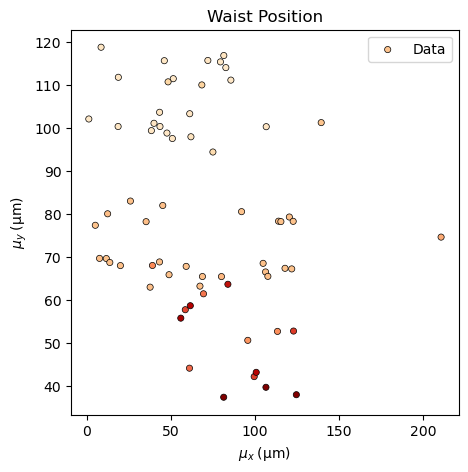

PyObject Text(0.5, 1.0, 'Waist Position')

In [66]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

norm_ind = summary_data.id #.- minimum(summary_data.id)
norm_ind = norm_ind ./ maximum(norm_ind)

# ax.scatter(
#     (summary_data.x .+ cos.(summary_data.α).*tan.(summary_data.θ).*1.478.*10^3).*1000, 
#     (summary_data.y .+ sin.(summary_data.α).*tan.(summary_data.θ).*1.478.*10^3).*1000,
#     edgecolors=plt.cm.OrRd.(norm_ind),
#     marker="*", s = 20, linewidths=0.5, facecolors="none", alpha=0.3, label="BTV53"
# #    , marker = "o",  edgecolors="k", 
# )

ax.scatter(
    (summary_data.x .+ cos.(summary_data.α).*tan.(summary_data.θ).*2.9.*10^3).*1000, 
    (summary_data.y .+ sin.(summary_data.α).*tan.(summary_data.θ).*2.9.*10^3).*1000,
    color=plt.cm.OrRd.(norm_ind), marker="o", s = 20, edgecolors="k", linewidths=0.5, label="Data"
)

ax.legend()

ax.set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax.set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")
ax.set_title("Waist Position")

In [20]:
charge_norm = summary_data.q ./ maximum(summary_data.q)
charge_norm[sortperm(charge_norm)] .= 1:length(charge_norm)
charge_norm = charge_norm ./ maximum(charge_norm);

In [21]:
pol_ang_log = log.(summary_data.θ)
pol_ang_log = pol_ang_log .- minimum(pol_ang_log)
pol_ang_log = pol_ang_log ./maximum(pol_ang_log);

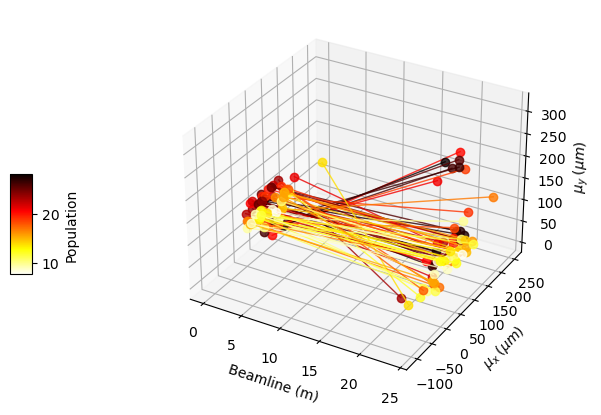

PyObject Text(0.10675873527355247, 0.014302958450758123, '$\\mu_y \\; (μm)$')

In [22]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(111, projection="3d")

smax = 24.0
    
for i in eachindex(summary_data.x)[end:-1:1]

    x_expected = cos(summary_data.α[i])*tan(summary_data.θ[i])*smax*10^3
    y_expected = sin(summary_data.α[i])*tan(summary_data.θ[i])*smax*10^3

    x = [summary_data.x[i], summary_data.x[i] + x_expected]*1000
    y = [summary_data.y[i], summary_data.y[i] + y_expected]*1000
    z = [0.0, smax]

    ax.plot(z, x, y,
        lw=1.0,
        color=plt.cm.hot_r(charge_norm[i]),  # charge_norm[i] pol_ang_log
        "o-", 
        alpha=0.8, 
    ) 
end

cb = ax.scatter(charge_norm, charge_norm, lw=0.0,  s=0.0, c=summary_data.q, cmap="hot_r")
ax_ins_3 = fig.add_axes([0.2,0.35,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

# ax.text2D(0.18, 0.25, "BTV50", color="k", transform=ax.transAxes)

ax.set_xlabel("Beamline (m)")
ax.set_ylabel(L"\mu_x \; (μm)")
ax.set_zlabel(L"\mu_y \; (μm)")